In [1]:
# Import python libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import erf
import pandas as pd
import math
#%matplotlib notebook

# Import the CCM modules
import leptoninjector as LI

# Make an instance of random for use 
random = LI.utilities.LI_random()

### Initial parameters

In [2]:
events_to_inject = 10000

### Define geometry

In [3]:
# Make the earth model, add ATLAS detector layout and materials file
materials_file = '../earthparams/materials/ATLAS.dat'
earth_model_file = '../earthparams/densities/PREM_ATLAS.dat'

earth_model = LI.detector.EarthModel()
earth_model.LoadMaterialModel(materials_file)
earth_model.LoadEarthModel(earth_model_file)

### Define injection processes

In [4]:
primary_type = LI.dataclasses.Particle.ParticleType.NuMu

primary_injection_process = LI.injection.InjectionProcess()
primary_injection_process.primary_type = primary_type

primary_physical_process = LI.injection.PhysicalProcess()
primary_physical_process.primary_type = primary_type

### Construct Cross Section Classes

In [5]:
xsfiledir = '/n/home01/awen/prometheus/resources/cross_section_splines'
target_type = LI.dataclasses.Particle.ParticleType.Nucleon

DIS_xs = LI.crosssections.DISFromSpline(xsfiledir+'/dsdxdy_nu_CC_iso.fits',
                                        xsfiledir+'/sigma_nu_CC_iso.fits',
                                        [primary_type],
                                        [target_type])

primary_xs = LI.crosssections.CrossSectionCollection(primary_type, [DIS_xs])
primary_injection_process.SetCrossSections(primary_xs)
primary_physical_process.SetCrossSections(primary_xs)

### Construct Energy Distributions

In [6]:
# input: file with energy (GeV) vs physical (time-integrated) total number of neutrinos at each energy
flux_file = '/n/home01/awen/LeptonInjector/Sandbox/flux_2P_D0_1_s20.txt'
edist = LI.distributions.TabulatedFluxDistribution(100, int(1e6), flux_file, False) #bool is whether flux is physical

primary_injection_process.AddInjectionDistribution(edist)
primary_physical_process.AddPhysicalDistribution(edist)

flux_units = LI.distributions.NormalizationConstant(3.76e-9) # normalize to a total number of events
primary_physical_process.AddPhysicalDistribution(flux_units)

(1e+30, 1e+53)

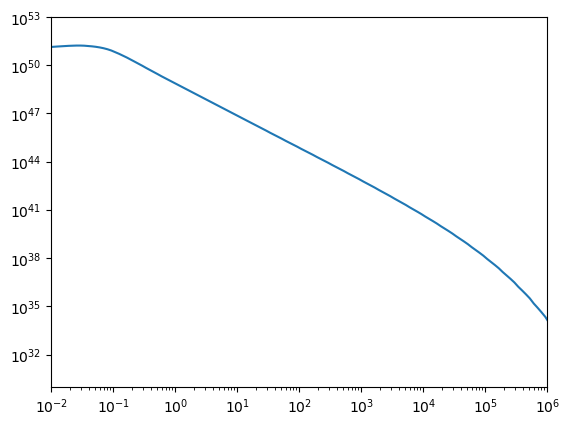

In [7]:
# plot dN spectrum just to show
flux_verify = np.loadtxt(flux_file)
plt.plot(flux_verify[:,0], flux_verify[:,1])
plt.xscale('log'); plt.xlim(1e-2, 1e6)
plt.yscale('log'); plt.ylim(1e30, 1e53)

### Construct Direction Distributions (position of injection, momentum of particle)

In [8]:
#ATLAS_origin = LI.math.Vector3D(0, 0, 6371234) #6371234 #90m below earth surface, ~depth of altas cavern
#earth_origin = LI.math.Vector3D(0, 0, 0)
#injection_dir = ATLAS_origin - earth_origin

# let's just inject upwards for throughgoing events at cos(theta) = -1
injection_dir = LI.math.Vector3D(0, 1, 0)
injection_dir.normalize()

inj_ddist = LI.distributions.FixedDirection(injection_dir)
phys_ddist = LI.distributions.FixedDirection(injection_dir)

primary_injection_process.AddInjectionDistribution(inj_ddist)
primary_physical_process.AddPhysicalDistribution(phys_ddist)

### Some other specifications: target at rest, neutrino helicity

In [9]:
target_momentum_distribution = LI.distributions.TargetAtRest()
primary_injection_process.AddInjectionDistribution(target_momentum_distribution)
primary_physical_process.AddPhysicalDistribution(target_momentum_distribution)

helicity_distribution = LI.distributions.PrimaryNeutrinoHelicityDistribution()
primary_injection_process.AddInjectionDistribution(helicity_distribution)
primary_physical_process.AddPhysicalDistribution(helicity_distribution)

### Position 
(Not necessary if using ColumnDepthLeptonInjector). However, define the volume anyways to calculate intersections with the produced muon

In [10]:
primary_pos_dist = None
fid_vol = None
for sector in earth_model.GetSectors():
    if sector.name=='muon_system':
        fid_vol = sector.geo
        primary_pos_dist = LI.distributions.CylinderVolumePositionDistribution(fid_vol)

#primary_injection_process.AddInjectionDistribution(primary_pos_dist)
#primary_physical_process.AddPhysicalDistribution(primary_pos_dist)

### Building the Injector

In [11]:
lepton_depth_function = LI.distributions.LeptonDepthFunction()

ATLAS_ColumnDepthInjector = LI.injection.ColumnDepthLeptonInjector(events_to_inject,
                                                                  earth_model,
                                                                  primary_injection_process,
                                                                  [],
                                                                  random, 
                                                                  lepton_depth_function, 
                                                                  23, 23) #radius, endcap length

# stopping condition for interaction tree generation
#
# this function should return true if the input datum should terminate
# the simulation for the current branch of the interaction
#
# for this test, stop after any secondary interaction tree datum is created
def StoppingCondition(datum):
    return True

ATLAS_ColumnDepthInjector.SetStoppingCondition(StoppingCondition)

### Building the weighter

In [12]:
ATLAS_weighter = LI.injection.LeptonTreeWeighter([ATLAS_ColumnDepthInjector], 
                                                 earth_model, 
                                                 primary_physical_process, 
                                                 []) #empty last argument since no secondary physical process

### Event Loop

In [13]:
vertex_xarray = np.asarray([])
vertex_yarray = np.asarray([])
vertex_zarray = np.asarray([])
lepton_energies = np.asarray([])
HadRecoil_energies = np.asarray([])
primary_energies = np.asarray([])
inter_array = []

weightarray = np.asarray([])
totalweightarray = np.asarray([])

for i in range(events_to_inject):
    tree = ATLAS_ColumnDepthInjector.GenerateEvent()
    weight = ATLAS_weighter.EventWeight(tree)
    
    totalweightarray = np.append(totalweightarray, weight)
    
    if not math.isinf(weight):
        print(i,end='\r')
        weightarray = np.append(weightarray, weight)
    
        for datum in tree.tree:
            vertex_xarray = np.append(vertex_xarray, LI.math.Vector3D(datum.record.interaction_vertex).GetX())
            vertex_yarray = np.append(vertex_yarray, LI.math.Vector3D(datum.record.interaction_vertex).GetY())
            vertex_zarray = np.append(vertex_zarray, LI.math.Vector3D(datum.record.interaction_vertex).GetZ())
            
            lepton_energies = np.append(lepton_energies, datum.record.secondary_momenta[0][0])
            HadRecoil_energies = np.append(HadRecoil_energies, datum.record.secondary_momenta[1][0])
            primary_energies = np.append(primary_energies, datum.record.primary_momentum[0])
    
            vtx = LI.math.Vector3D(datum.record.interaction_vertex)
            #vtx = LI.math.Vector3D([vtx.GetX(), vtx.GetY(), vtx.GetZ()/100])
            lepton_direction = LI.math.Vector3D(datum.record.secondary_momenta[0][1:])
            
            inter = fid_vol.ComputeIntersections(vtx, lepton_direction)
            
            if len(inter) != 0: 
                #print('found intersection!')
                inter_array.append(inter)

### Plot of positions of vertices

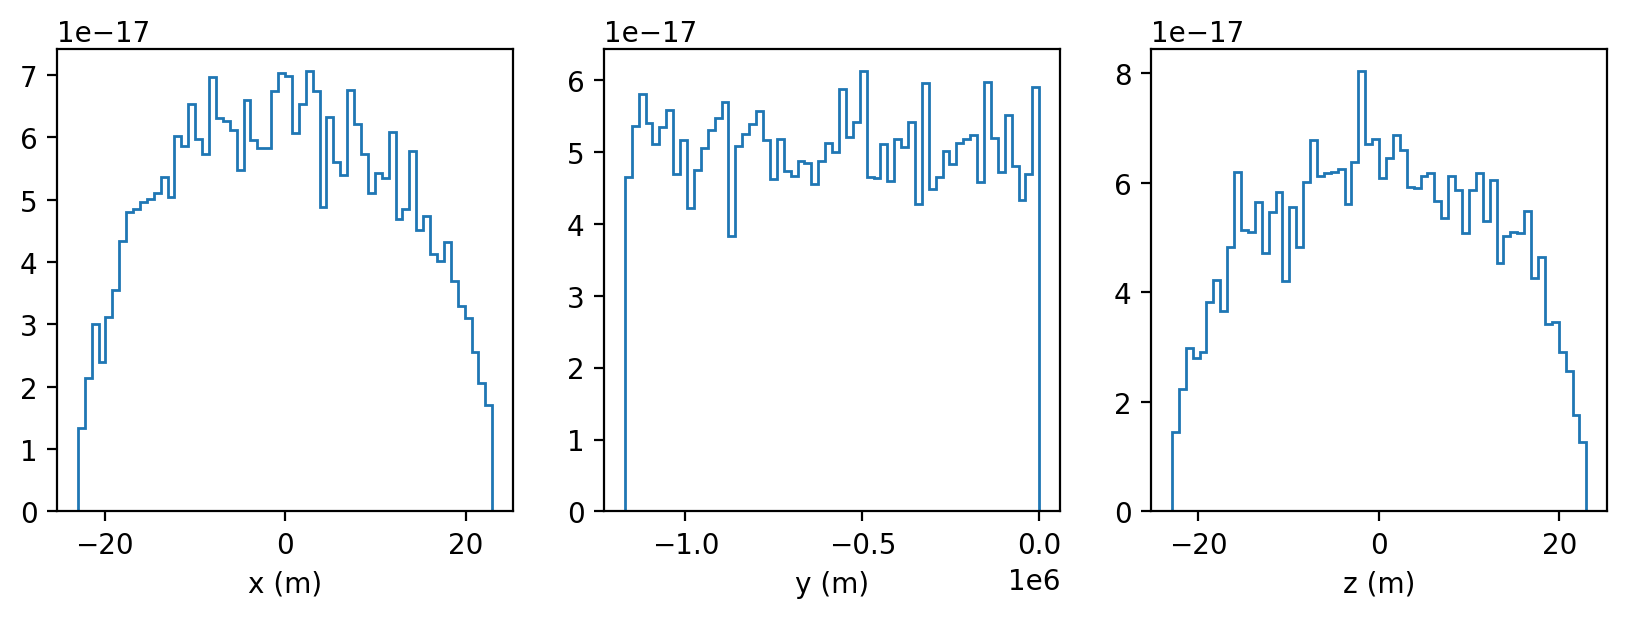

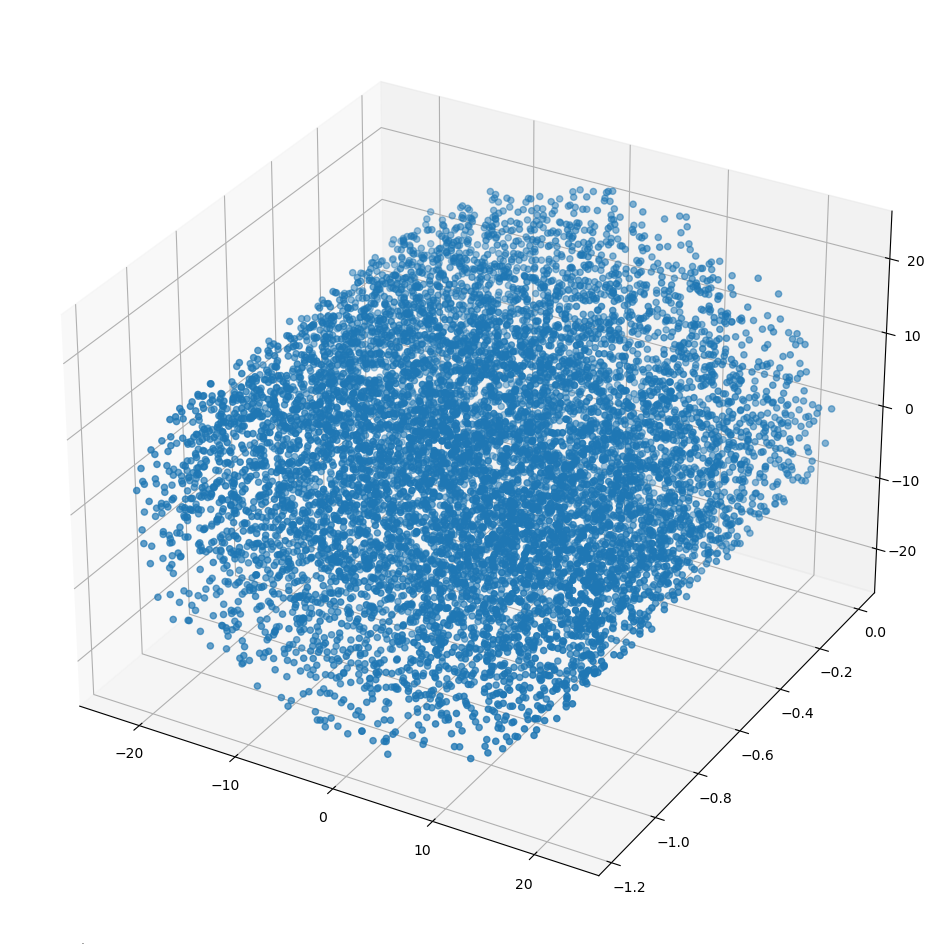

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), dpi=200)
counts, bins = np.histogram(vertex_xarray, weights=weightarray, bins=60)
ax1.stairs(counts, bins, label='lepton')
ax1.set_xlabel('x (m)')

counts, bins = np.histogram(vertex_yarray, weights=weightarray, bins=60)
ax2.stairs(counts, bins, label='lepton')
ax2.set_xlabel('y (m)')

counts, bins = np.histogram(vertex_zarray, weights=weightarray, bins=60)
ax3.stairs(counts, bins, label='lepton')
ax3.set_xlabel('z (m)')

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(vertex_xarray, vertex_yarray, vertex_zarray)

### Plotting where the lepton intersects the detector volume

(-12.0, 12.0)

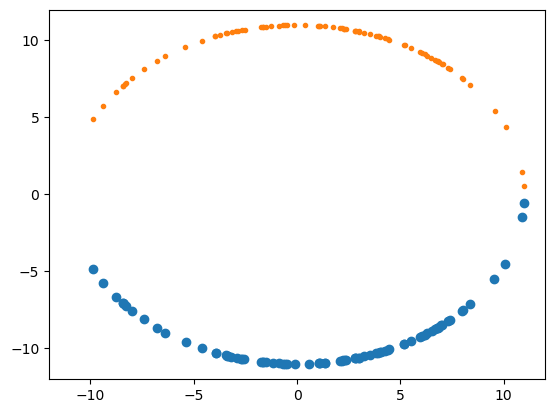

In [15]:
X_inter_array = []
Y_inter_array = []
Z_inter_array = []

for i in inter_array: 
    for j in i: 
        X_inter_array.append(j.position.GetX())
        Y_inter_array.append(j.position.GetY())
        Z_inter_array.append(j.position.GetZ())

plt.figure()
plt.scatter(X_inter_array[::2], Y_inter_array[::2])
plt.scatter(X_inter_array[1:][::2], Y_inter_array[1:][::2], marker='.')
plt.xlim(-12,12)
plt.ylim(-12,12)

### Plotting the Energy Spectrum at the primary vertex

Text(0.5, 0, 'Energy (GeV)')

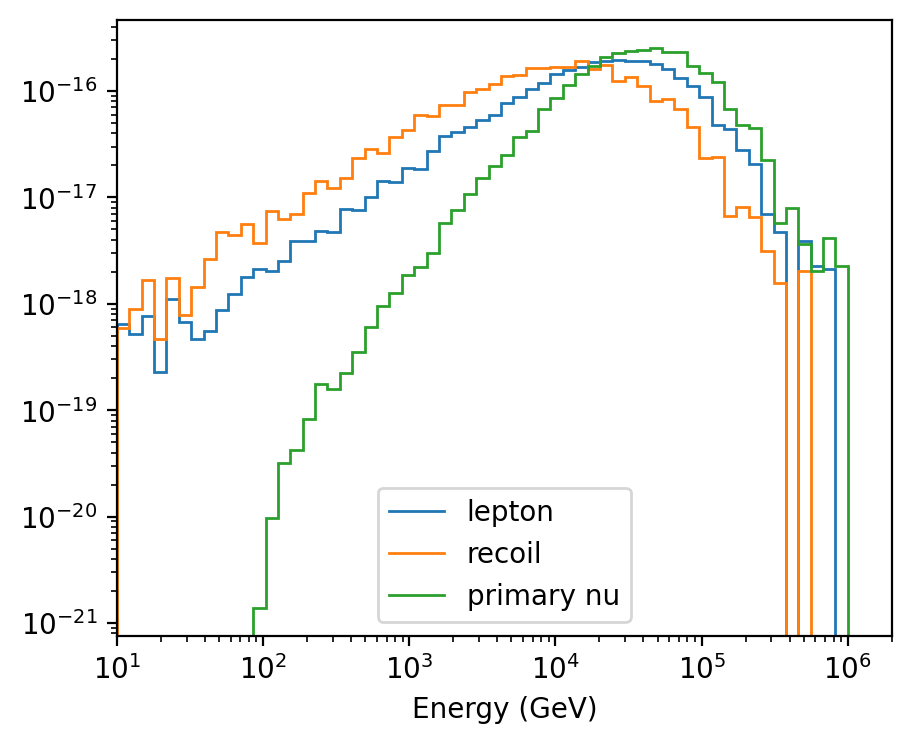

In [19]:
fig = plt.figure(figsize=(5, 4), dpi=200)

counts, bins = np.histogram(lepton_energies, weights=weightarray, bins=np.logspace(np.log10(1e1),np.log10(1e6), 60))
counts2, bins2 = np.histogram(HadRecoil_energies, weights=weightarray, bins=np.logspace(np.log10(1e1),np.log10(1e6), 60))
counts3, bins3 = np.histogram(primary_energies, weights=weightarray, bins=np.logspace(np.log10(1e1),np.log10(1e6), 60))
#counts, bins = np.histogram(zarray, bins=100)
plt.stairs(counts, bins, label='lepton')
plt.stairs(counts2, bins2, label='recoil')
plt.stairs(counts3, bins3, label='primary nu')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e1, 2e6)
plt.legend()
plt.xlabel('Energy (GeV)')

### Distribution of weights

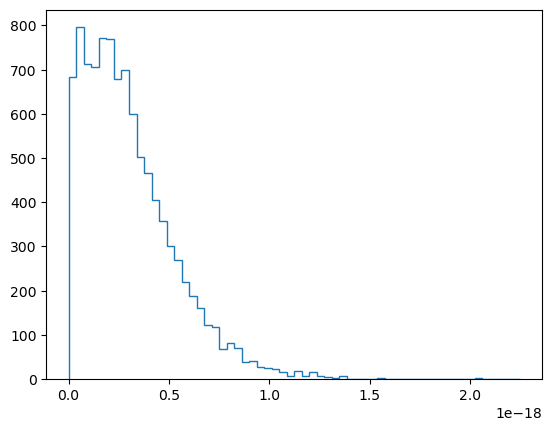

In [17]:
counts, bins = np.histogram(weightarray, bins=60)
plt.stairs(counts, bins)
#plt.yscale('log')

### Some playing around for Finding intersections

In [18]:
tree = ATLAS_ColumnDepthInjector.GenerateEvent()
datum = None

for datum in tree.tree: # loop over interactions in the tree
    if(datum.record.signature.primary_type == LI.dataclasses.Particle.ParticleType.NuTau):
        print(LI.math.Vector3D(datum.record.interaction_vertex).GetX())
        print(LI.math.Vector3D(datum.record.interaction_vertex).GetY())
        print(LI.math.Vector3D(datum.record.interaction_vertex).GetZ())

weight = ATLAS_weighter.EventWeight(tree)
#print(weight)

vtx = LI.math.Vector3D(datum.record.interaction_vertex)
lepton_direction = LI.math.Vector3D(datum.record.secondary_momenta[0][1:])

inter = fid_vol.ComputeIntersections(vtx, lepton_direction)

inter[0].position.GetZ()

IndexError: list index out of range